# Модель предсказания количества заявок на потребительский кредит

На основе данных о регионах России, скачанных с сайта [Kaggle](https://www.kaggle.com/vitaliymalcev/sberbank-open-data-eng), попробуем создать модель, предсказывающую количество заявок на потребительский кредит на основе других имеющихся экономических показателей.

## Загрузка библиотек и данных

In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import HTML
style = "<style>svg{width:70% !important; height:70% !important;}</style>"
HTML(style)

In [3]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#тюнит параметры с помощью кросс-валидации
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [10]:
data = pd.read_csv("~/data/df.csv", index_col="region", parse_dates=True)

## Предобработка данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74842 entries, Russia to Yaroslavskaya oblast
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    74842 non-null  object
 1   date    74842 non-null  object
 2   value   74842 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [6]:
data.describe()

,value
count,7.484200e+04
mean,2.018732e+05
std,4.527957e+05
min,1.000000e+00
25%,1.412000e+03
50%,1.395050e+04
75%,1.992958e+05
max,6.631650e+06


In [7]:
data.shape

(74842, 3)

In [8]:
data["name"].unique()

array(['The number of applications for consumer loans',
       'Average consumer loan application',
       'The number of applications for mortgages',
       'The average amount of a mortgage application',
       'Number of new deposits', 'Average amount of new deposit',
       'Average salary', 'Average pension',
       'On average rubles on current account per person',
       'On average, deposits in rubles per person',
       'Average spending on cards', 'Average Fast Food format Check',
       'Average check in Restaurant format',
       'Average spending in a fast food restaurant',
       'Average spending in a restaurant'], dtype=object)

Полезные для модели параметры находятся в столбце 'name', разнесём их по отдельным столбцам.

In [11]:
new = data.pivot_table(index=["region", "date"], columns="name", values="value", aggfunc="mean", fill_value=0).reset_index()

In [13]:
new.head()

name,region,date,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
0,Altai region,2013-01-15,0,0,0,133509,0,0,0,0,0,0,0,0,968154,13423,508
1,Altai region,2013-02-15,0,0,0,150030,0,0,0,0,0,0,0,0,957201,12440,641
2,Altai region,2013-03-15,0,0,0,151795,0,0,0,0,0,0,0,0,974481,15906,853
3,Altai region,2013-04-15,0,0,0,148752,0,0,0,0,0,0,0,0,985195,22172,1072
4,Altai region,2013-05-15,0,0,0,150903,0,0,0,0,0,0,0,0,955750,22642,807


In [12]:
new.describe()

name,Average Fast Food format Check,Average amount of new deposit,Average check in Restaurant format,Average consumer loan application,Average pension,Average salary,Average spending in a fast food restaurant,Average spending in a restaurant,Average spending on cards,Number of new deposits,On average rubles on current account per person,"On average, deposits in rubles per person",The average amount of a mortgage application,The number of applications for consumer loans,The number of applications for mortgages
count,6132.000000,6.132000e+03,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6132.000000,6.132000e+03,6132.000000,6.132000e+03,6.132000e+03,6.132000e+03,6132.000000
mean,217.309361,2.347876e+05,380.931670,230029.326647,11926.290770,19553.695042,613.514025,998.156556,7458.347847,3.745632e+04,17084.223092,3.378201e+05,1.541666e+06,2.143624e+04,2464.977332
std,168.651108,2.053471e+05,321.926864,71376.895421,6548.561829,17544.850796,494.643900,826.886805,5165.053964,2.019944e+05,12471.079767,2.632673e+05,4.788155e+05,1.040387e+05,11856.415242
min,0.000000,0.000000e+00,0.000000,116468.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,0.000000
25%,0.000000,1.611165e+05,0.000000,183257.750000,10321.000000,0.000000,0.000000,0.000000,4417.750000,1.232500e+03,11804.500000,2.347342e+05,1.217118e+06,4.148500e+03,377.000000
50%,295.000000,2.276035e+05,442.500000,210423.500000,12943.000000,21038.000000,767.000000,1210.000000,7184.500000,1.224550e+04,15980.000000,3.191910e+05,1.406126e+06,7.772000e+03,773.000000
75%,341.000000,3.051988e+05,608.250000,251209.250000,15044.250000,28039.250000,976.000000,1578.250000,10107.500000,2.545900e+04,20914.500000,4.138628e+05,1.705787e+06,1.403900e+04,1564.000000
max,597.000000,6.631650e+06,1646.000000,875000.000000,88132.000000,123204.000000,2298.000000,3508.000000,30273.000000,4.732173e+06,87712.000000,2.093545e+06,4.600000e+06,2.175857e+06,182146.000000


С помощью графика рассмотрим как зависят друг от друга размер потребительского кредита и размер ипотеки. Видно, что они достаточно сильно коррелируют между собой.

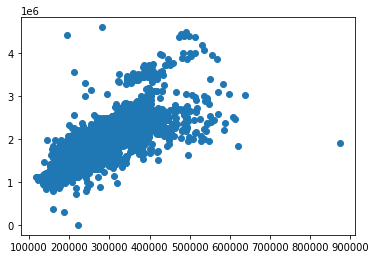

In [14]:
plt.scatter(new["Average consumer loan application"], new["The average amount of a mortgage application"]);

Построим тепловую карту, чтобы проанализировать, какие из параметров можно удалить из-за сильной корреляции

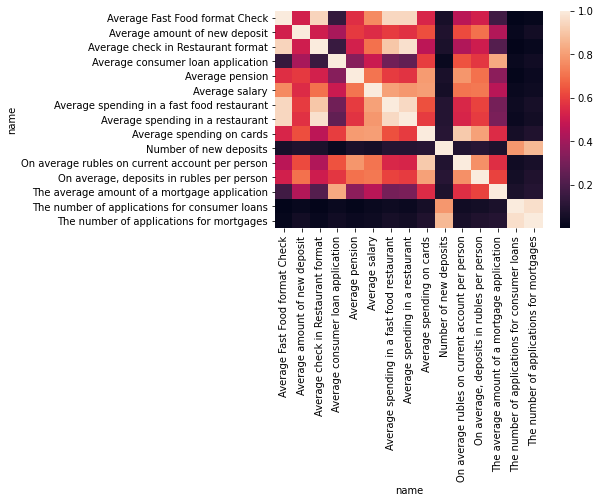

In [15]:
sns.heatmap(new.corr());

In [18]:
new[new['Average salary'] != 0]['Average salary'].mean()

29131.015063168124

In [19]:
new['Average salary'].mean()

19553.695042400523

In [24]:
new = new[new["region"] != "Russia"]

In [126]:
k = {}
for nval in new:
    for value in new[nval]:
        if(value == 0):
            nval = nval.replace(" ", "")
            k[nval] = 1 if nval not in k else k[nval] + 1
print(k)

{'AverageFastFoodformatCheck': 2158, 'Averageamountofnewdeposit': 1162, 'AveragecheckinRestaurantformat': 2158, 'Averagepension': 996, 'Averagesalary': 1992, 'Averagespendinginafastfoodrestaurant': 2158, 'Averagespendinginarestaurant': 2158, 'Averagespendingoncards': 996, 'Numberofnewdeposits': 1162, 'Onaveragerublesoncurrentaccountperperson': 996, 'Onaverage,depositsinrublesperperson': 996, 'Theaverageamountofamortgageapplication': 1, 'Thenumberofapplicationsformortgages': 1}


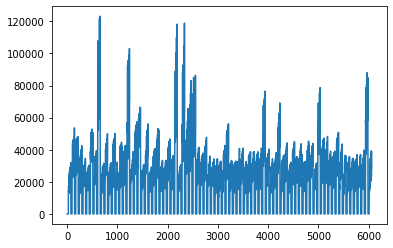

In [649]:
new["Average salary"].plot()

In [140]:
df_mean_by_region = new.groupby(["region"]).mean()

In [157]:
mean_without_index = df_mean_by_region.reset_index()

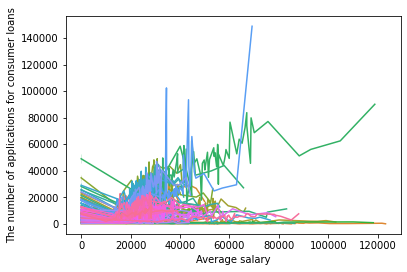

In [28]:
sns.lineplot(x="Average salary", y="The number of applications for consumer loans", hue="region", data = new, legend=False)

На примере взаимосвязи количества заявок на потребительский кредит и количества заявок на ипотеки рассмотрим, насколько сильно выбиваются из показателей регионов столицы и их области.

На графике ниже представлены все регионы

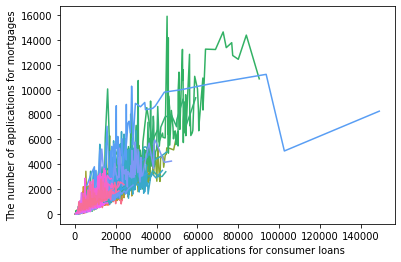

In [25]:
sns.lineplot(x="The number of applications for consumer loans", y="The number of applications for mortgages", hue="region", data = new, legend=False);

Создадим таблицу, исключив из неё Москву, Московскую области и Санкт-Петербург

In [ ]:
without_moskow = new[(new["region"] != "Moscow") & (new["region"] != "Moscow region") & (new["region"] != "St. Petersburg")]

Из графика ниже видно, что большие выбросы скорее всего создавали именно эти регионы. Поэтому, будем разрабатывать модель для регионов, исключив столицы и Московскую область.

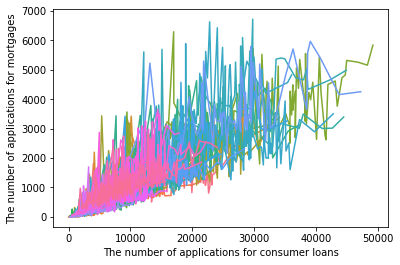

In [27]:
sns.lineplot(x="The number of applications for consumer loans", y="The number of applications for mortgages", hue="region", data = without_moskow, legend=False);

## Дерево решений

Создадим дерево решений для предсказывания параметра "Количество заявок на потребительские кредиты" и посмотрим, какие параметры имеют наибольшое влияние на него.

In [30]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date"], axis=1)
y = without_moskow["The number of applications for consumer loans"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_split=100, min_samples_leaf=10)

In [32]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=10,
                       min_samples_split=100)

Наибольшее влияние имеют параметры, относящиеся к ипотеки.

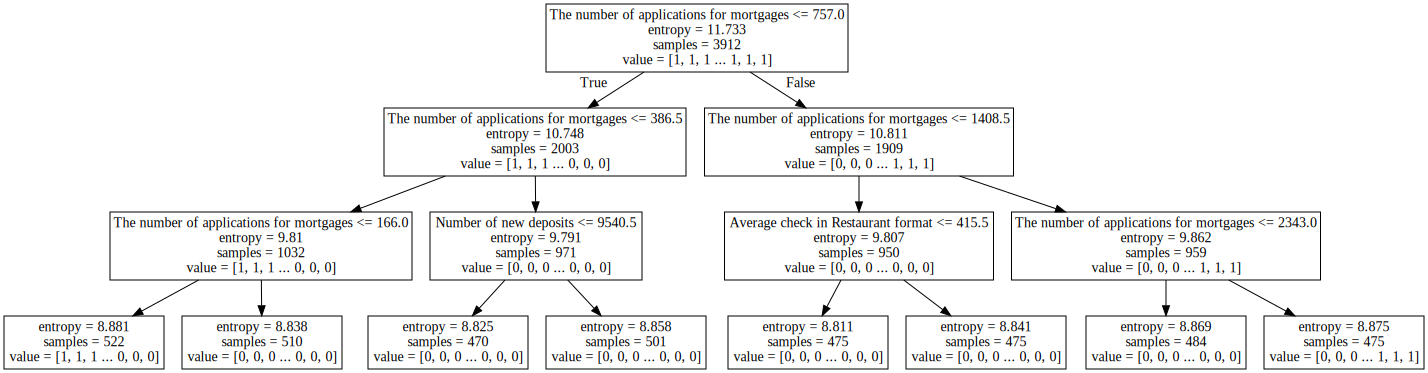

In [33]:
graph = Source(tree.export_graphviz(clf, out_file=None,
                                   feature_names=list(X_train)))
display(SVG(graph.pipe(format='svg')))

## Взаимосвязь интересующего параметра со всеми остальными

Рассмотрим детальнее взаимосвязь параметра "Количество заявок на потребительский кредит" со всеми другими с помощью графиков.

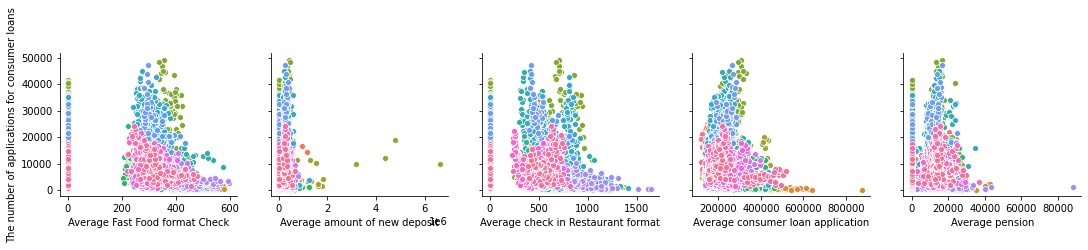

In [307]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["Average Fast Food format Check", "Average amount of new deposit", "Average check in Restaurant format", "Average consumer loan application", "Average pension"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

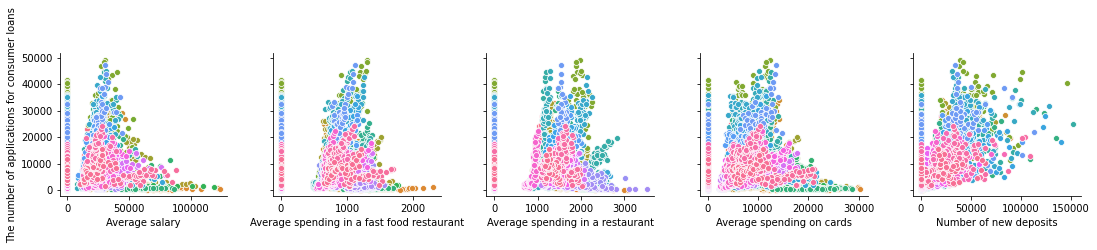

In [308]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["Average salary", "Average spending in a fast food restaurant", "Average spending in a restaurant", "Average spending on cards", "Number of new deposits"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

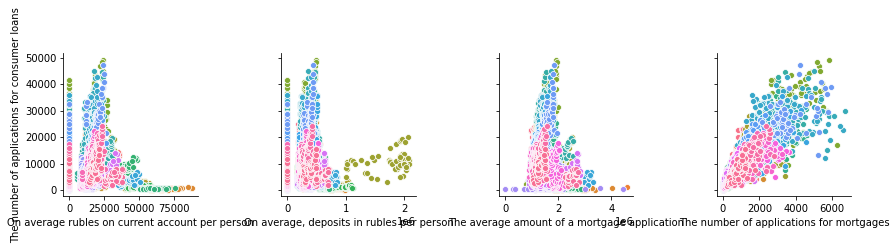

In [309]:
sns.pairplot(data=without_moskow, hue="region", x_vars=["On average rubles on current account per person", "On average, deposits in rubles per person", "The average amount of a mortgage application", "The number of applications for mortgages"], y_vars=["The number of applications for consumer loans"], height=3)._legend.remove()

Из графиков видно, что выраженную линейную зависимость с предсказываемой переменной имеют столбцы "Количество новых депозитов" и "Количество заявок на ипотеку", они не помогут нашей модели лучше предсказывать данные, поэтому можем их удалить.

Рассмотрим распределение значений количества заявок на потребительские кредиты с помощью гистограммы.

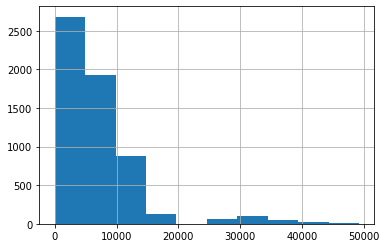

In [79]:
pl = without_moskow["The number of applications for consumer loans"]
pl.hist();

Поскольку у нас мало данных для предсказывания точного количества заявок, проранжируем количество заявок от 0 до 5, где:
  * от 0 до 4000 - 0
  * от 4001 до 8000 - 1
  * от 8001 до 12000 - 2
  * от 12001 до 16000 - 3
  * от 16001 до 20000 - 4
  * от 20001 и более - 5

In [ ]:
without_moskow["range"] = without_moskow["The number of applications for consumer loans"] // 4000

In [39]:
#эксперимент с ранжированием
without_moskow[(without_moskow["range"] >= 4) & (without_moskow["range"] < 7)] = 4
without_moskow["range"][without_moskow["range"] >= 7] = 5

/home/tanya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
# Заметка: такое ранжирование вносит порядок туда, где его нет. поэтому лучше разнести на отдельные столбцы эти данные.
# Надо поресёчить.

## Random Forest

In [80]:
X = without_moskow.drop(["The number of applications for consumer loans", "region", "date", "range"], axis=1)
y = without_moskow["range"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [81]:
clf = RandomForestClassifier()

In [82]:
parameters = {'n_estimators': [10, 20, 30, 40, 50], 'max_depth': [1, 3, 5, 7, 9, 11], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], 'min_samples_split': [2, 4, 6, 8]}

In [83]:
grid_search = GridSearchCV(clf, parameters, cv=3)

In [84]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7],
                         'min_samples_split': [2, 4, 6, 8],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [85]:
grid_search.best_params_

{'max_depth': 11,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 40}

In [86]:
best_tree = grid_search.best_estimator_

In [87]:
feature_importances = best_tree.feature_importances_

Построим график параметров, которые больше всех помогают предсказать значение параметра

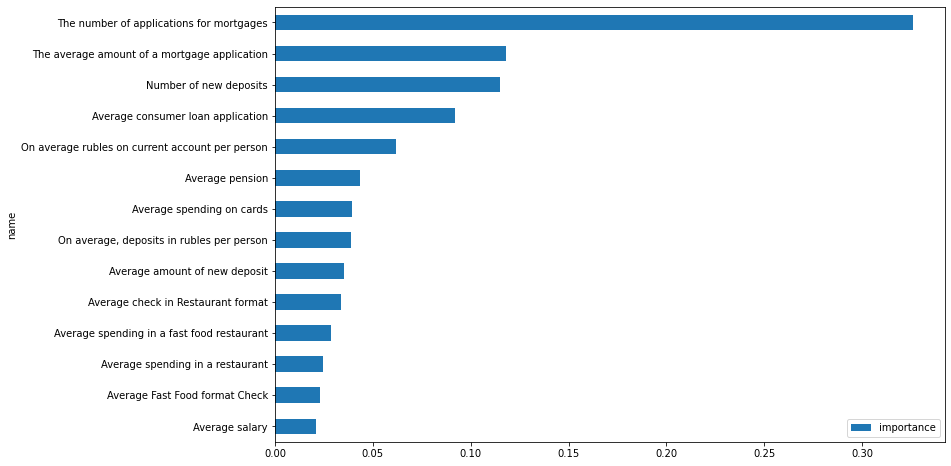

In [88]:
imp = pd.DataFrame(feature_importances, index=X.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8));

Созданная нами модель имеет следующую точность:

In [89]:
best_tree.score(X_test, y_test)

0.7645228215767634